---
date: last-modified
---

# Plotting polar cloud variables from PREFIRE data

## Summary

This notebook shows how to retrieve and plot cloud values for the polar region, from [Polar Radiant Energy in the Far-InfraRed Experiment (PREFIRE)](https://asdc.larc.nasa.gov/project/PREFIRE) data.

## Prerequisites

- cartopy
- earthaccess
- matplotlib
- netCDF4
- numpy

### Notebook Authors / Affiliation

Alex Radkevich / Atmospheric Science Data Center (ASDC)

# Installing libraries

In [1]:
# Install external dependencies
#!pip install -qq python-cmr # these are installed in OPENSCAPES, in other environments may need to be installed first
#!pip install -qq gnss_lib_py # this might be needed to work with GPS time

# Importing libraries

In [2]:
from datetime import datetime  # needed to work with time in plotting time series
import getpass
import requests

import cartopy.crs as ccrs
import earthaccess  # needed to discover and download TEMPO data
import matplotlib.pyplot as plt  # needed to plot the resulting time series
import netCDF4 as nc  # needed to read TEMPO data
import numpy as np


# function to read data

In [3]:
def read_PREFIRE_2B_CLD(fn):
    try:
        with nc.Dataset(fn) as ds:
            geo = ds.groups["Geometry"]
            var = geo.variables["ctime"]
            ctime = np.ma.getdata(var[:])

            var = geo.variables["ctime_minus_UTC"]
            ctime_minus_UTC = np.ma.getdata(var[:])

            var = geo.variables["latitude"]
            lat = np.ma.getdata(var[:])

            var = geo.variables["longitude"]
            lon = np.ma.getdata(var[:])

            var = geo.variables["time_UTC_values"]
            time_UTC = np.ma.getdata(var[:])

            Cld = ds.groups["Cld"]
            var = Cld.variables["cld_qc_bitflags"]
            bitQF = np.ma.getdata(var[:])

            var = Cld.variables["cloud_d_eff"]
            cloud_d_eff = np.ma.getdata(var[:])
            fv_cloud_d_eff = var.get_fill_value()

            var = Cld.variables["cloud_tau"]
            cloud_tau = np.ma.getdata(var[:])
            fv_cloud_tau = var.get_fill_value()

            var = Cld.variables["cloudtop_pressure"]
            cloudtop_pressure = np.ma.getdata(var[:])
            fv_cloudtop_pressure = var.get_fill_value()

    except Exception:
        ctime = 0.0
        ctime_minus_UTC = 0.0
        lat = 0.0
        lon = 0.0
        time_UTC = 0.0
        bitQF = 0.0
        cloud_d_eff = 0.0
        fv_cloud_d_eff = 0.0
        cloud_tau = 0.0
        fv_cloud_tau = 0.0
        cloudtop_pressure = 0.0
        fv_cloudtop_pressure = 0.0

    return (
        ctime,
        ctime_minus_UTC,
        lat,
        lon,
        time_UTC,
        bitQF,
        cloud_d_eff,
        fv_cloud_d_eff,
        cloud_tau,
        fv_cloud_tau,
        cloudtop_pressure,
        fv_cloudtop_pressure,
    )

## Using earthaccess library
see

https://earthaccess.readthedocs.io/en/latest/

for more details on this library

### login to Earthdata via earthaccess

In [4]:
# User needs to create an account at https://www.earthdata.nasa.gov/
# Function earthaccess.login prompts for EarthData login and password.
auth = earthaccess.login(strategy="interactive", persist=True)

Enter your Earthdata Login username:  hazem.mahmoud88
Enter your Earthdata password:  ········


### define a function to get collection ID from its short_name and version

In [5]:
def get_collectionID_earthaccess(short_name, version):
    collectionID = "-1"

    results = earthaccess.search_datasets(short_name=short_name, version=version)

    if len(results) == 1:
        collectionID = results[0]["meta"]["concept-id"]
    else:
        raise Exception("Specify valid collection")

    return collectionID

In [6]:
short_name = "PREFIRE_SAT2_2B-CLD"
version = "R01"
collectionID = get_collectionID_earthaccess(short_name, version)
print(
    f"collectionID for collection short_name {short_name} and version {version} is {collectionID}"
)

collectionID for collection short_name PREFIRE_SAT2_2B-CLD and version R01 is C3499264827-LARC_CLOUD


### getting collection ID

# Search for granules using earthaccess library
specify timeframe and/or boundingbox of interest

In [7]:
short_name = "PREFIRE_SAT2_2B-CLD"  # collection name
version = "R01"  # version of the collection

yyyy = 2024
mm = 9
dd = 1

date_start = str("%4.4i-%2.2i-%2.2i 00:00:00" % (yyyy, mm, dd))
date_end = str("%4.4i-%2.2i-%2.2i 06:00:00" % (yyyy, mm, dd))

results_earthaccess = earthaccess.search_data(
    short_name=short_name,
    version=version,
    # bounding_box: a tuple representing spatial bounds in the form
    # (lower_left_lon, lower_left_lat, upper_right_lon, upper_right_lat)
    # where -180 <= lower_left_lon, upper_right_lon < 180,
    #        -90 <= lower_left_lat, upper_right_lat <= 90
    bounding_box=(-180.0, 60.0, 180.0, 90.0),
    temporal=(date_start, date_end),
)
PREFIRE_names = sorted([r["meta"]["native-id"] for r in results_earthaccess])
for name in PREFIRE_names:
    print(name)

PREFIRE_SAT2_2B-CLD_R01_P00_20240831222721_01490.nc
PREFIRE_SAT2_2B-CLD_R01_P00_20240901013749_01492.nc
PREFIRE_SAT2_2B-CLD_R01_P00_20240901031303_01493.nc
PREFIRE_SAT2_2B-CLD_R01_P00_20240901044818_01494.nc


### compare outcome with Earthdata Search results

!["comparison with EDS granules search outcome"](EDS_search_for_granules_05-30-2025_02.png)

# Download granules with earthaccess

## One-by-one

In [8]:
PREFIRE_links = sorted([r.data_links() for r in results_earthaccess])
for link in PREFIRE_links:
    print(link)
    granule = earthaccess.download(link, local_path=".")

['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/PREFIRE/PREFIRE_SAT2_2B-CLD_R01/2024.08.31/PREFIRE_SAT2_2B-CLD_R01_P00_20240831222721_01490.nc']


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/PREFIRE/PREFIRE_SAT2_2B-CLD_R01/2024.09.01/PREFIRE_SAT2_2B-CLD_R01_P00_20240901013749_01492.nc']


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/PREFIRE/PREFIRE_SAT2_2B-CLD_R01/2024.09.01/PREFIRE_SAT2_2B-CLD_R01_P00_20240901031303_01493.nc']


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

['https://data.asdc.earthdata.nasa.gov/asdc-prod-protected/PREFIRE/PREFIRE_SAT2_2B-CLD_R01/2024.09.01/PREFIRE_SAT2_2B-CLD_R01_P00_20240901044818_01494.nc']


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

## All at once

In [9]:
# remove downloaded granules for demonstration
!rm *.nc

In [10]:
granules = earthaccess.download(results_earthaccess, local_path=".")

QUEUEING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/4 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/4 [00:00<?, ?it/s]

# Plotting variables cloud_d_eff, cloud_tau, cloudtop_pressure

## North Pole

for the South Pole
the two lines need to be changed in the cell below

    1) projection definition:

    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0, globe=None) # North Pole
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0, globe=None) # South Pole

    2) extent of the plot:

    ax1.set_extent([0., 360., 60., 90.], crs=transform) # North Pole
    ax1.set_extent([0., 360., -90., -60.], crs=transform) # South Pole

# Plot the variables from the original granules

Processing file: PREFIRE_SAT2_2B-CLD_R01_P00_20240831222721_01490.nc
Time range: 2024-08-31 22:27:21 2024-09-01 00:02:34


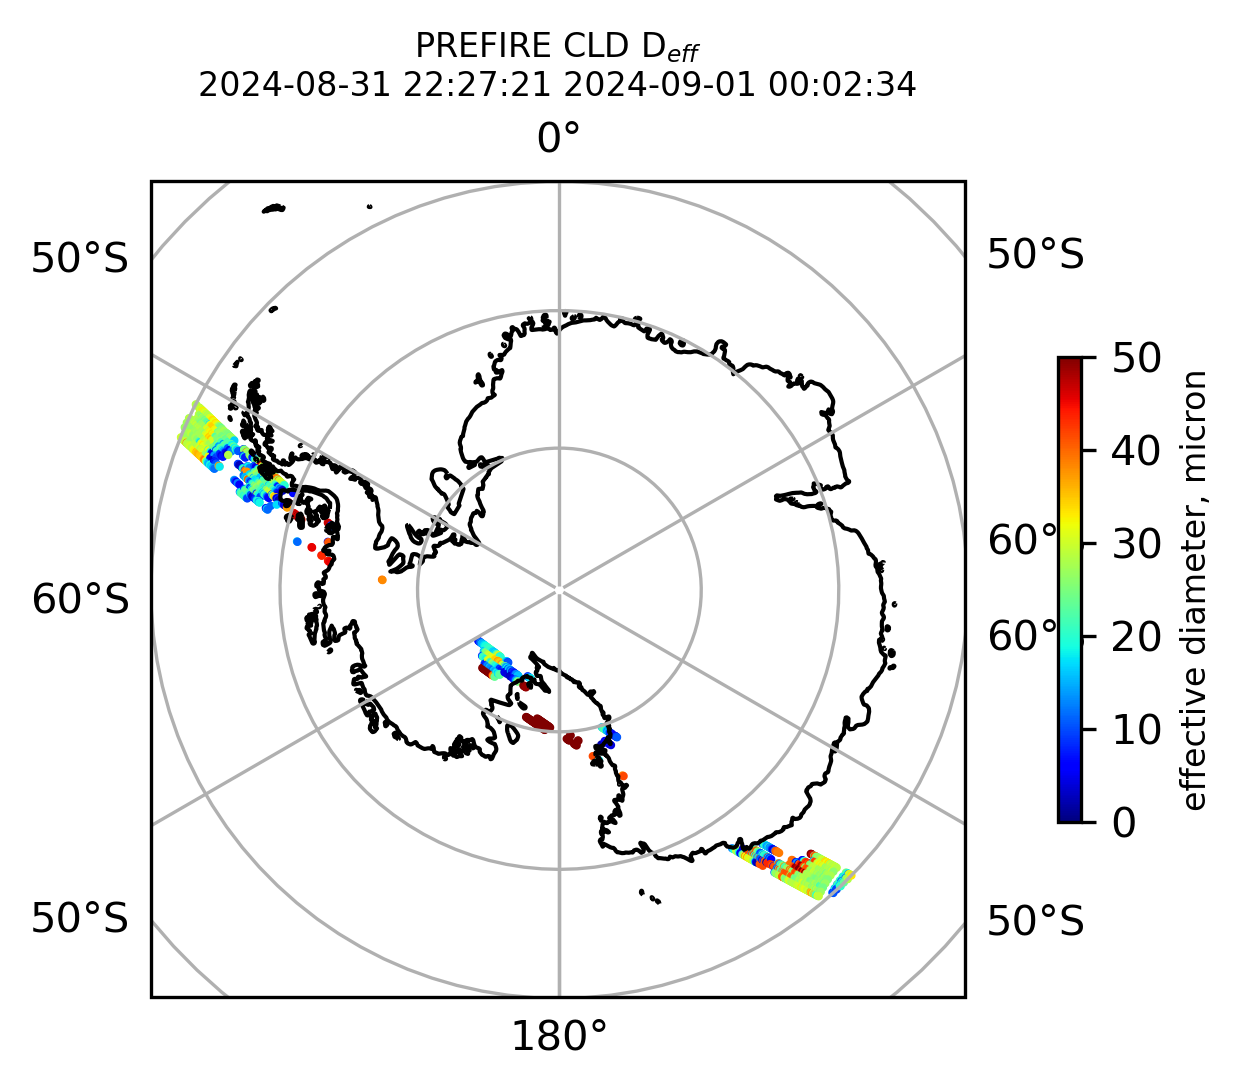

Generated plot for cloud effective diameter


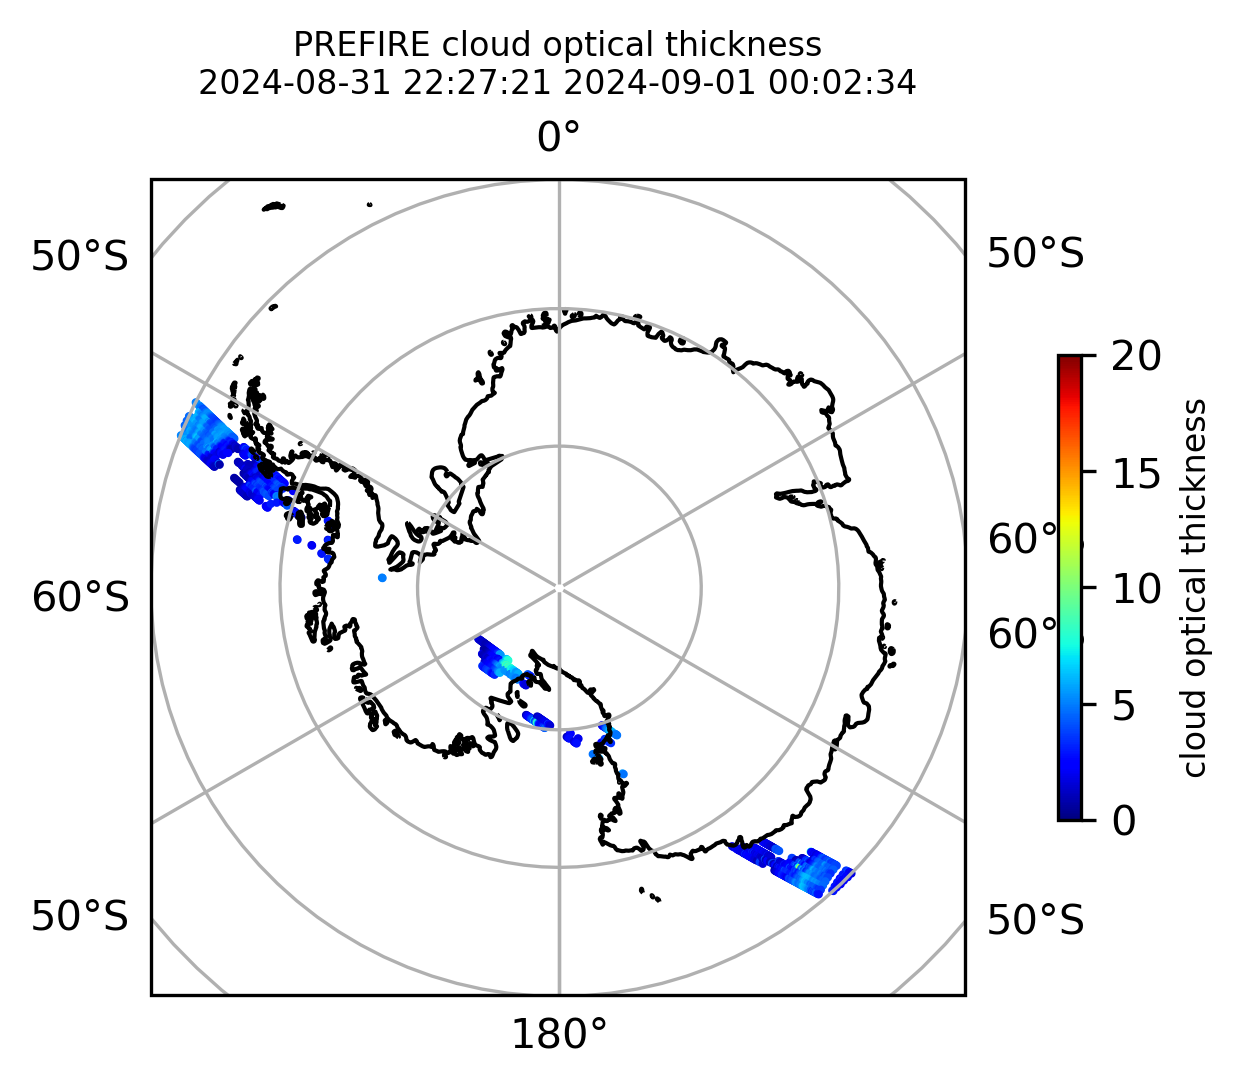

Generated plot for cloud optical thickness


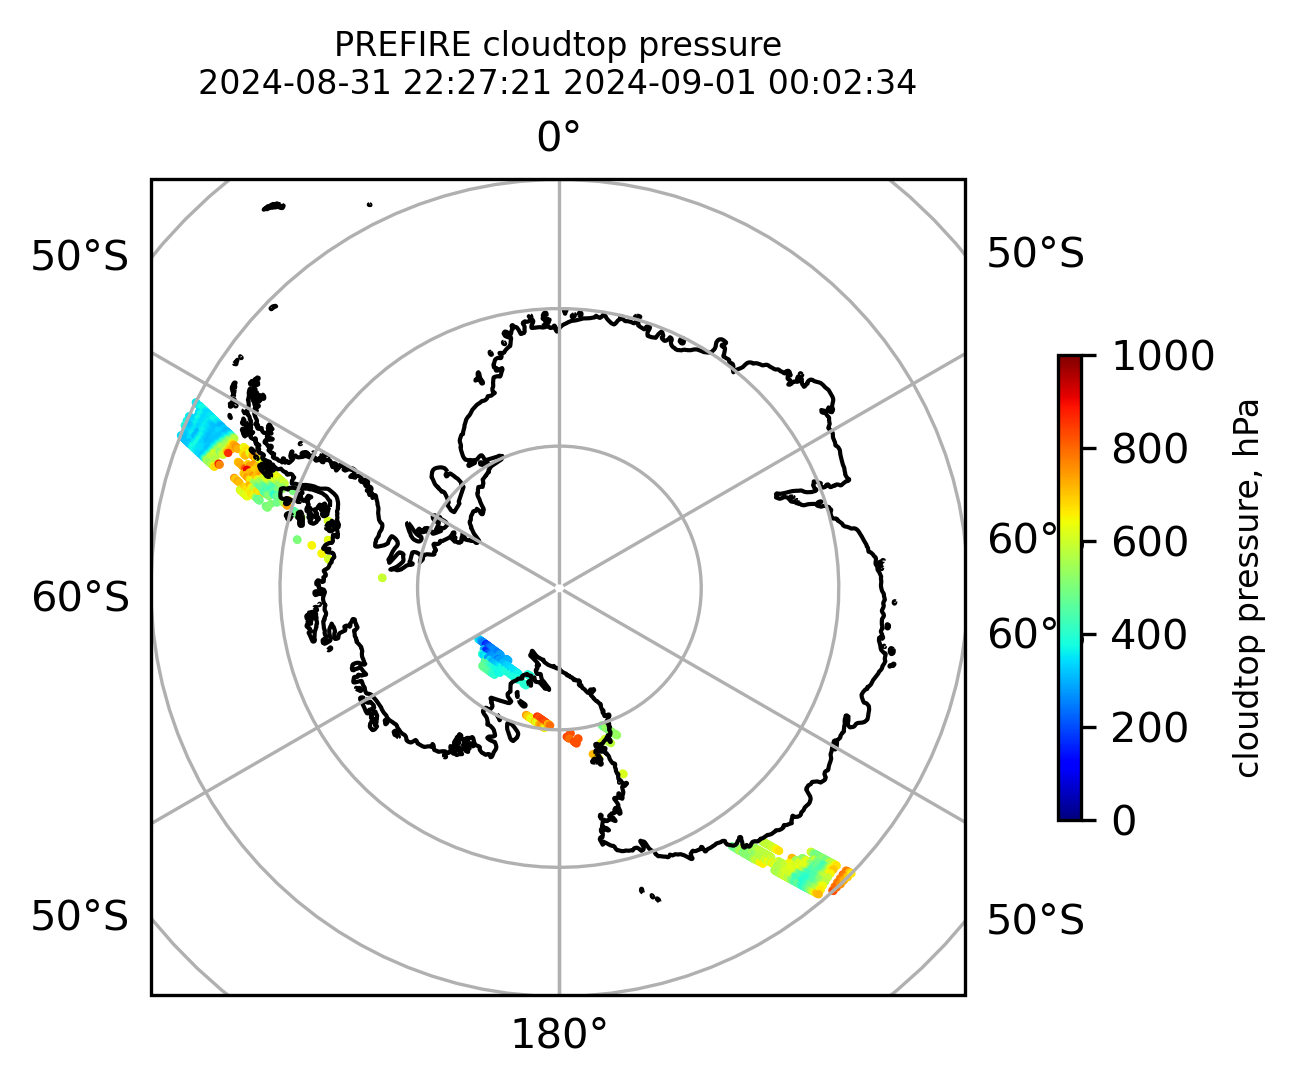

Generated plot for cloudtop pressure
Processing file: PREFIRE_SAT2_2B-CLD_R01_P00_20240901013749_01492.nc
Time range: 2024-09-01 01:37:49 2024-09-01 03:13:03


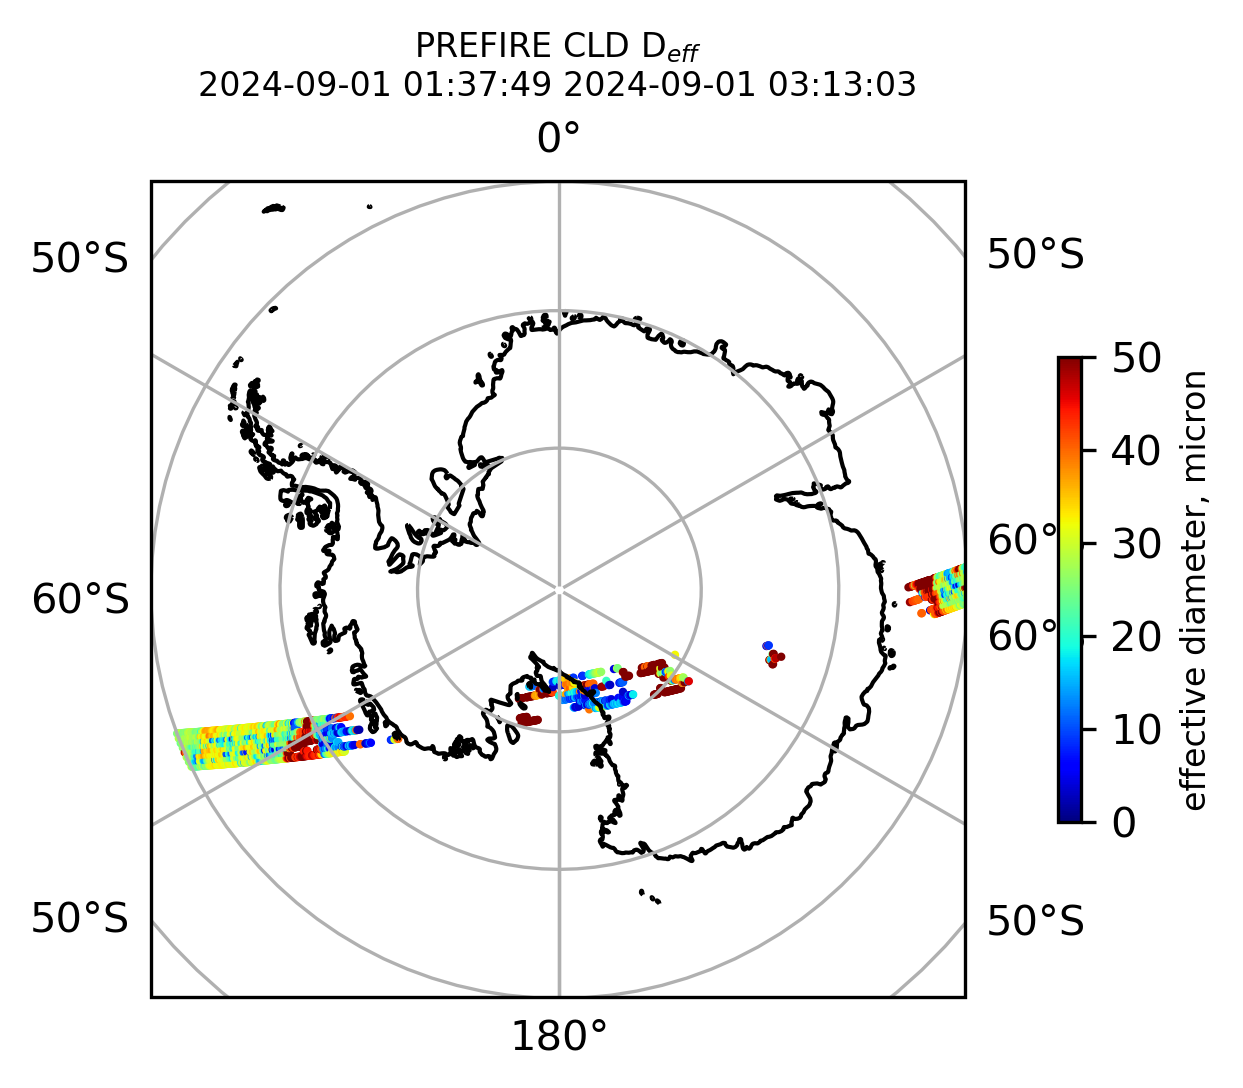

Generated plot for cloud effective diameter


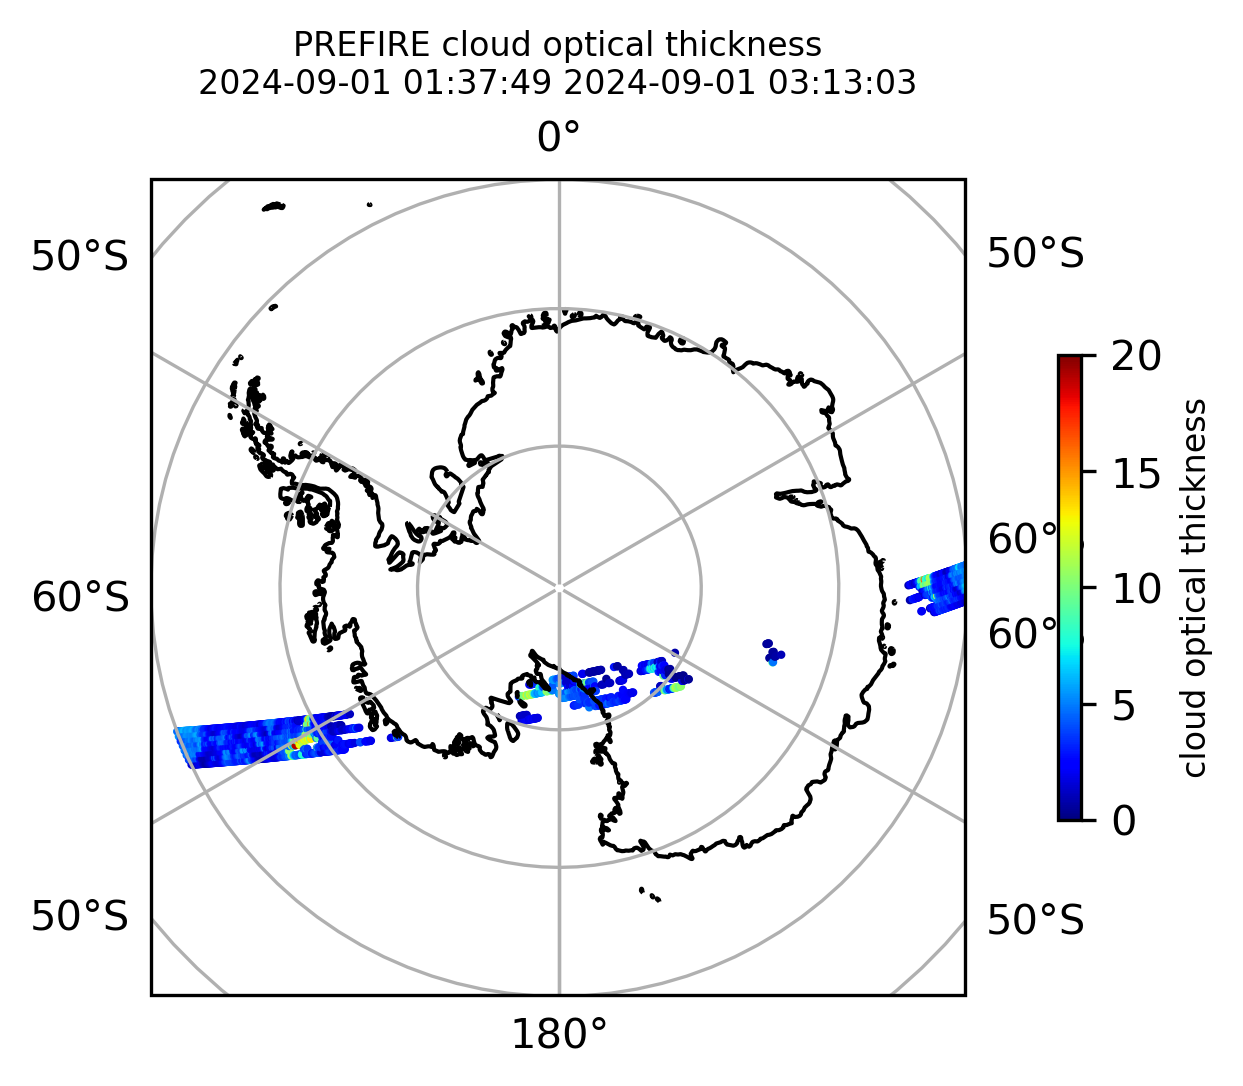

Generated plot for cloud optical thickness


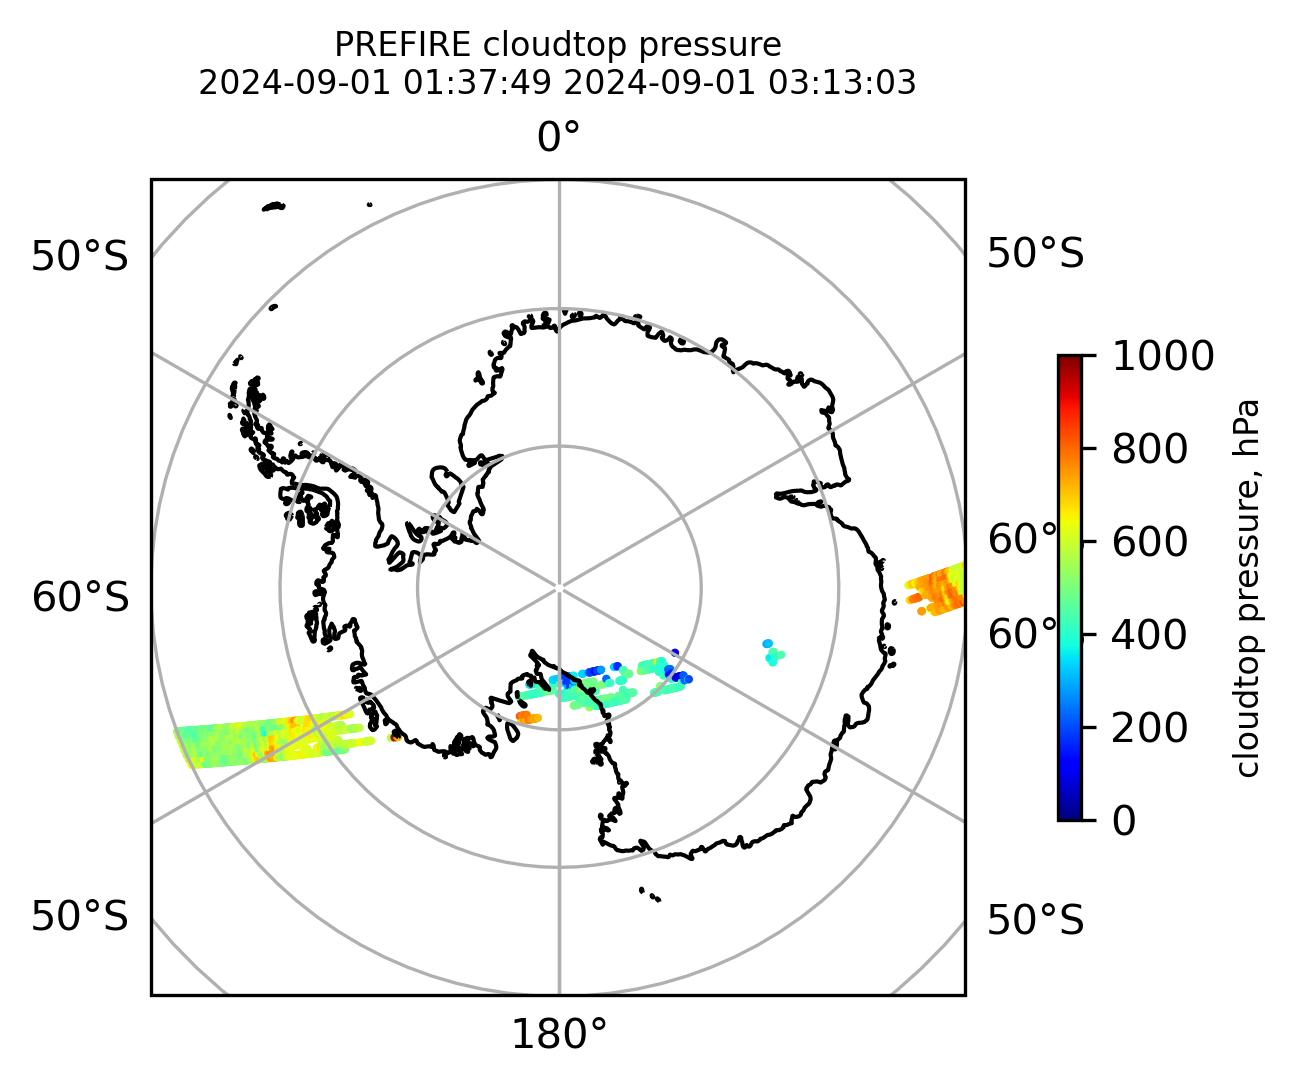

Generated plot for cloudtop pressure
Processing file: PREFIRE_SAT2_2B-CLD_R01_P00_20240901031303_01493.nc
Time range: 2024-09-01 03:13:03 2024-09-01 04:48:17


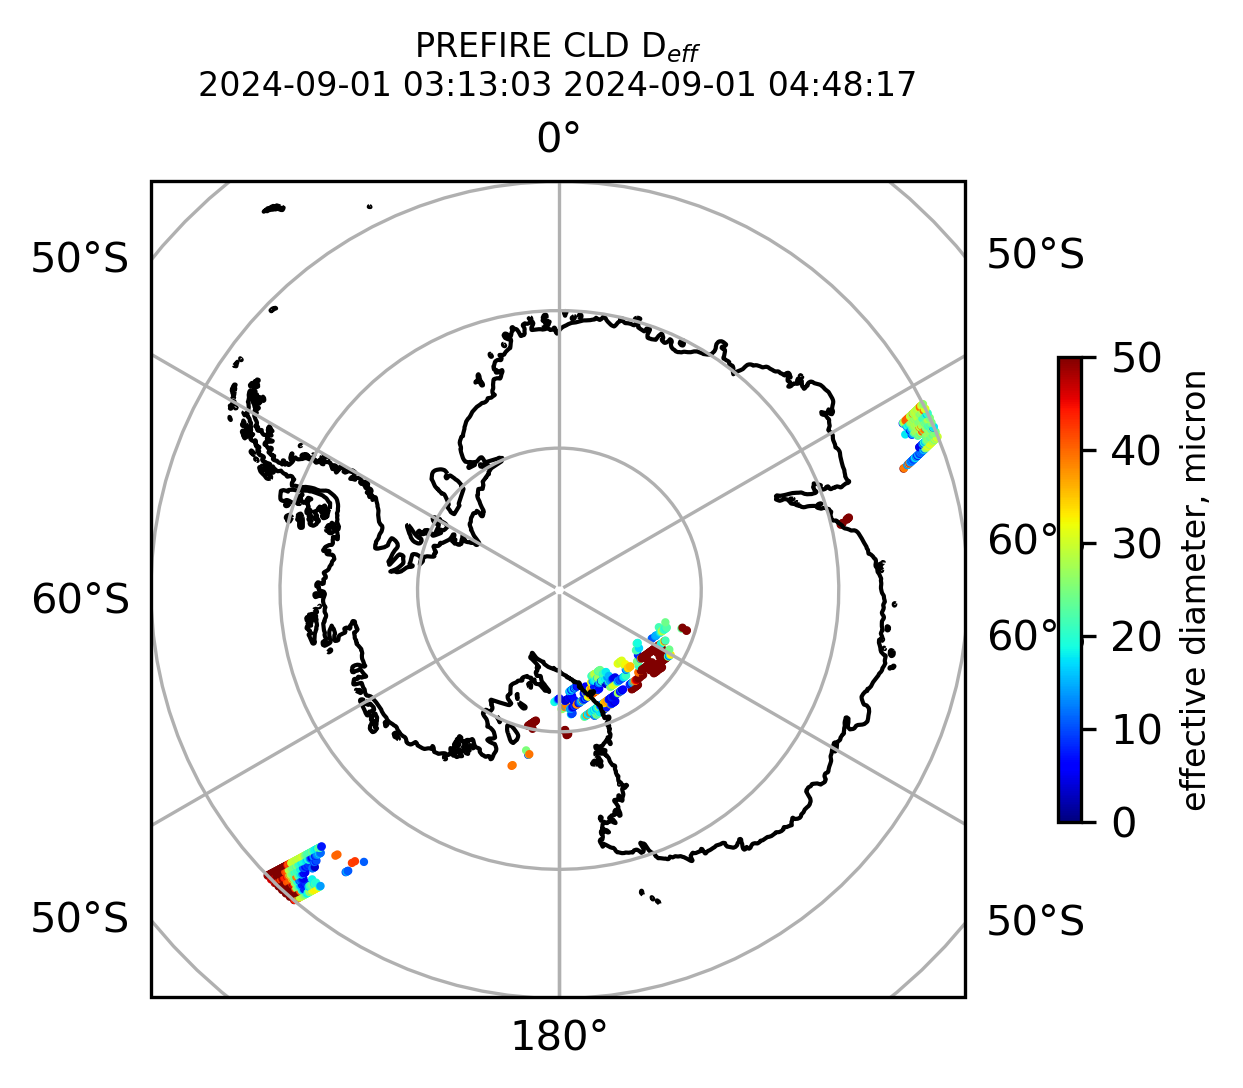

Generated plot for cloud effective diameter


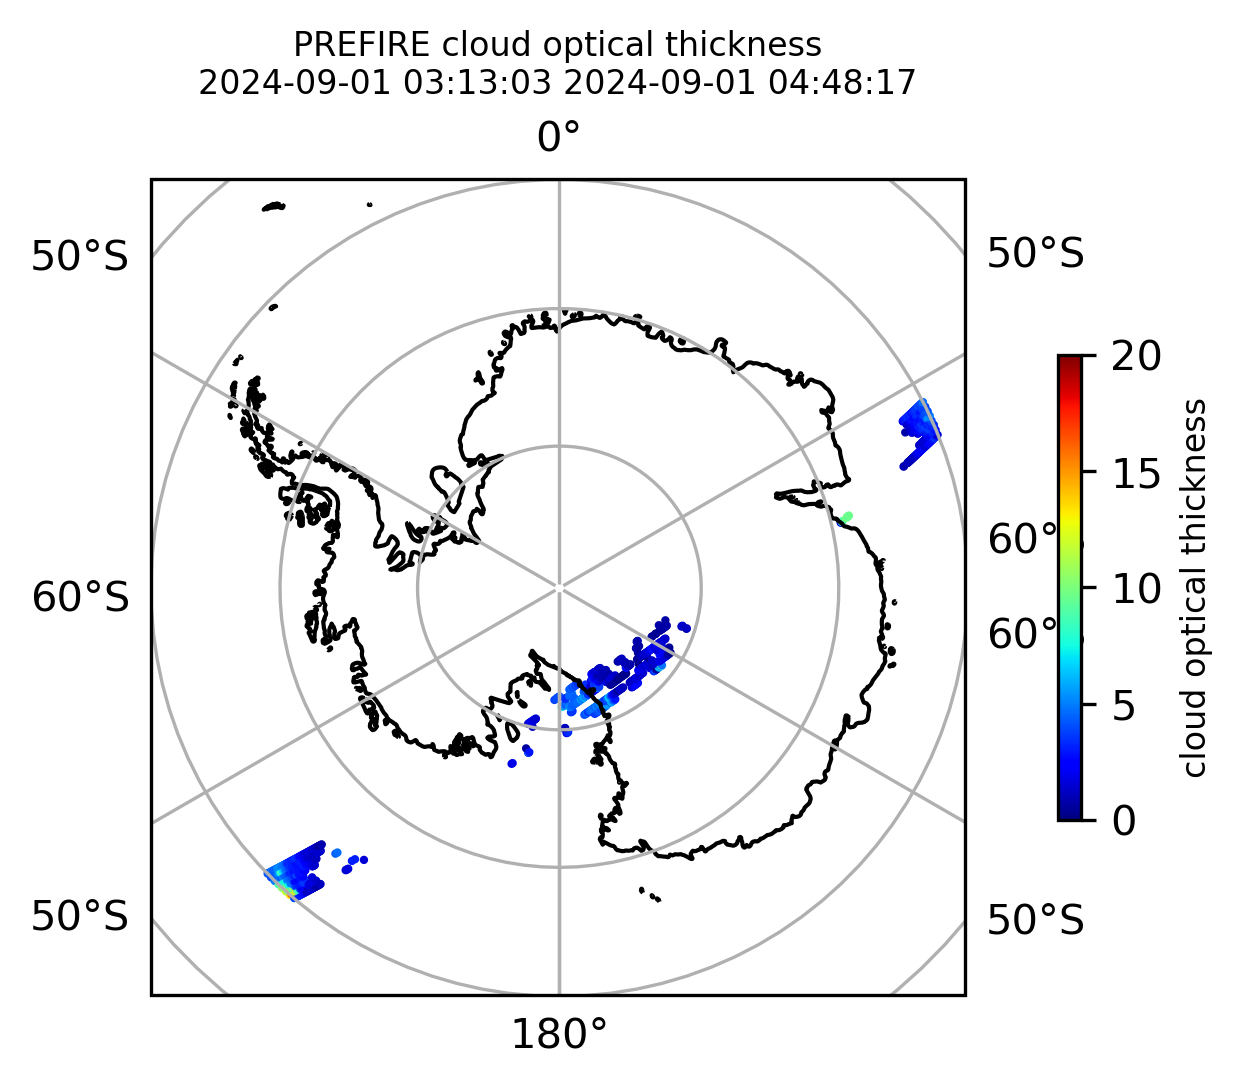

Generated plot for cloud optical thickness


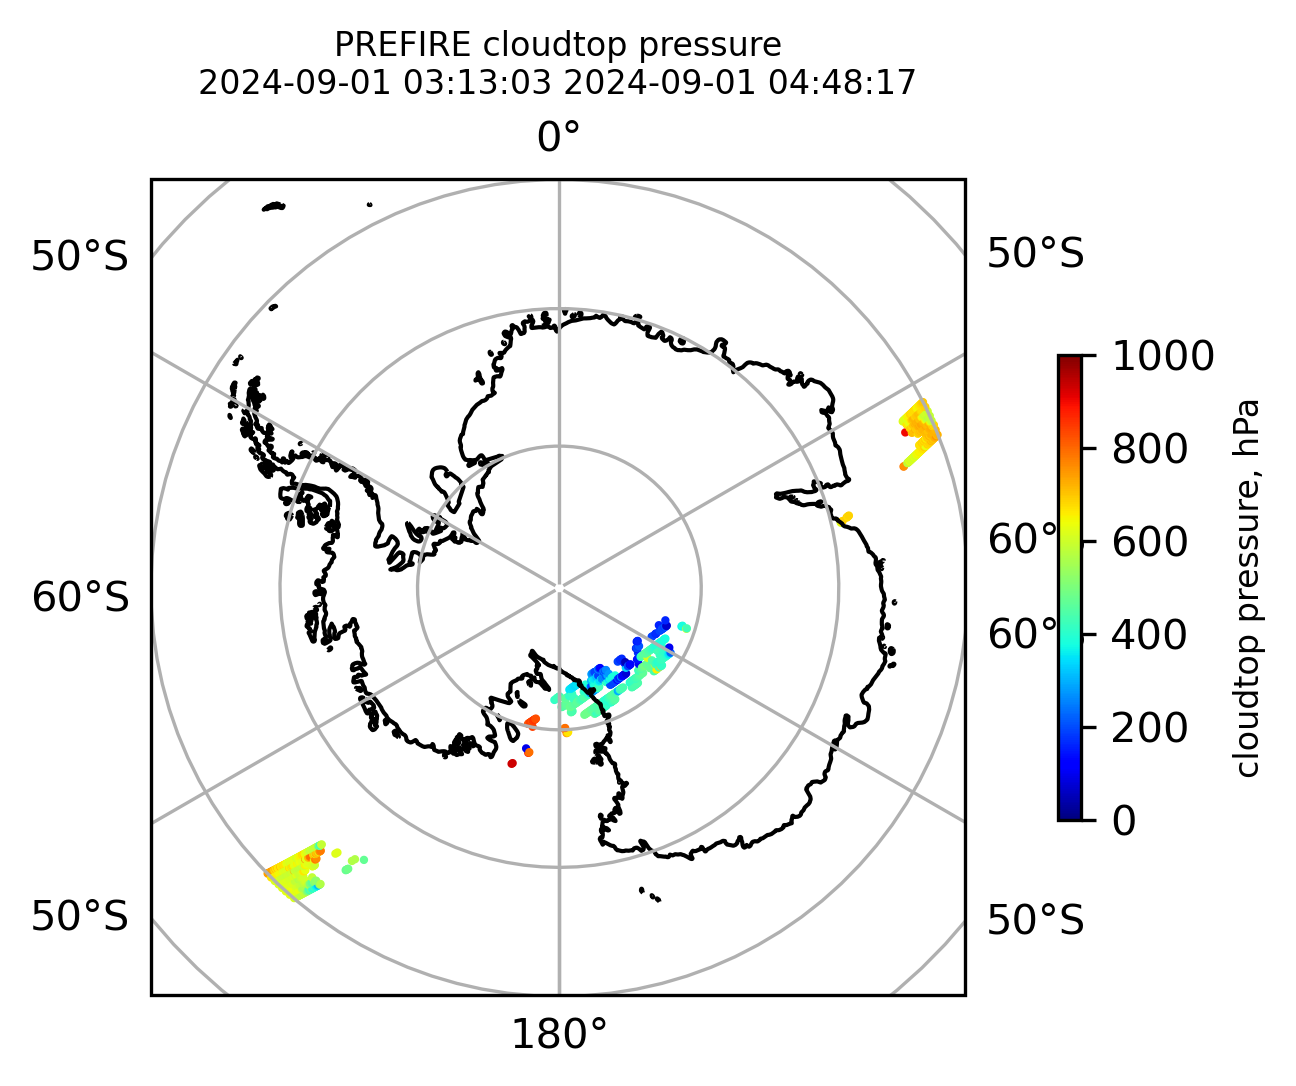

Generated plot for cloudtop pressure
Processing file: PREFIRE_SAT2_2B-CLD_R01_P00_20240901044818_01494.nc
Time range: 2024-09-01 04:48:18 2024-09-01 06:23:31


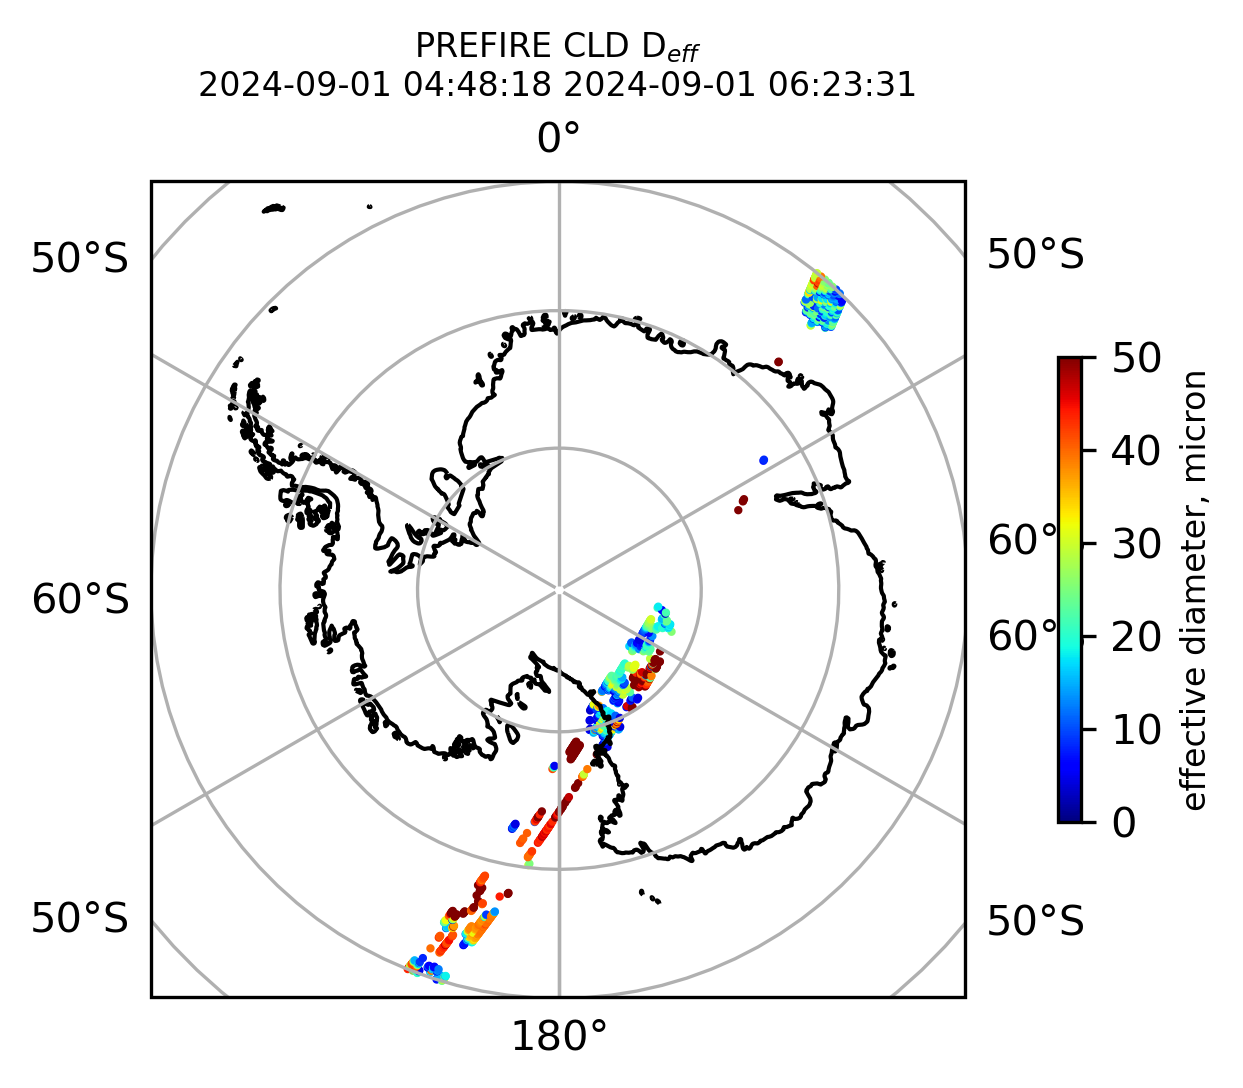

Generated plot for cloud effective diameter


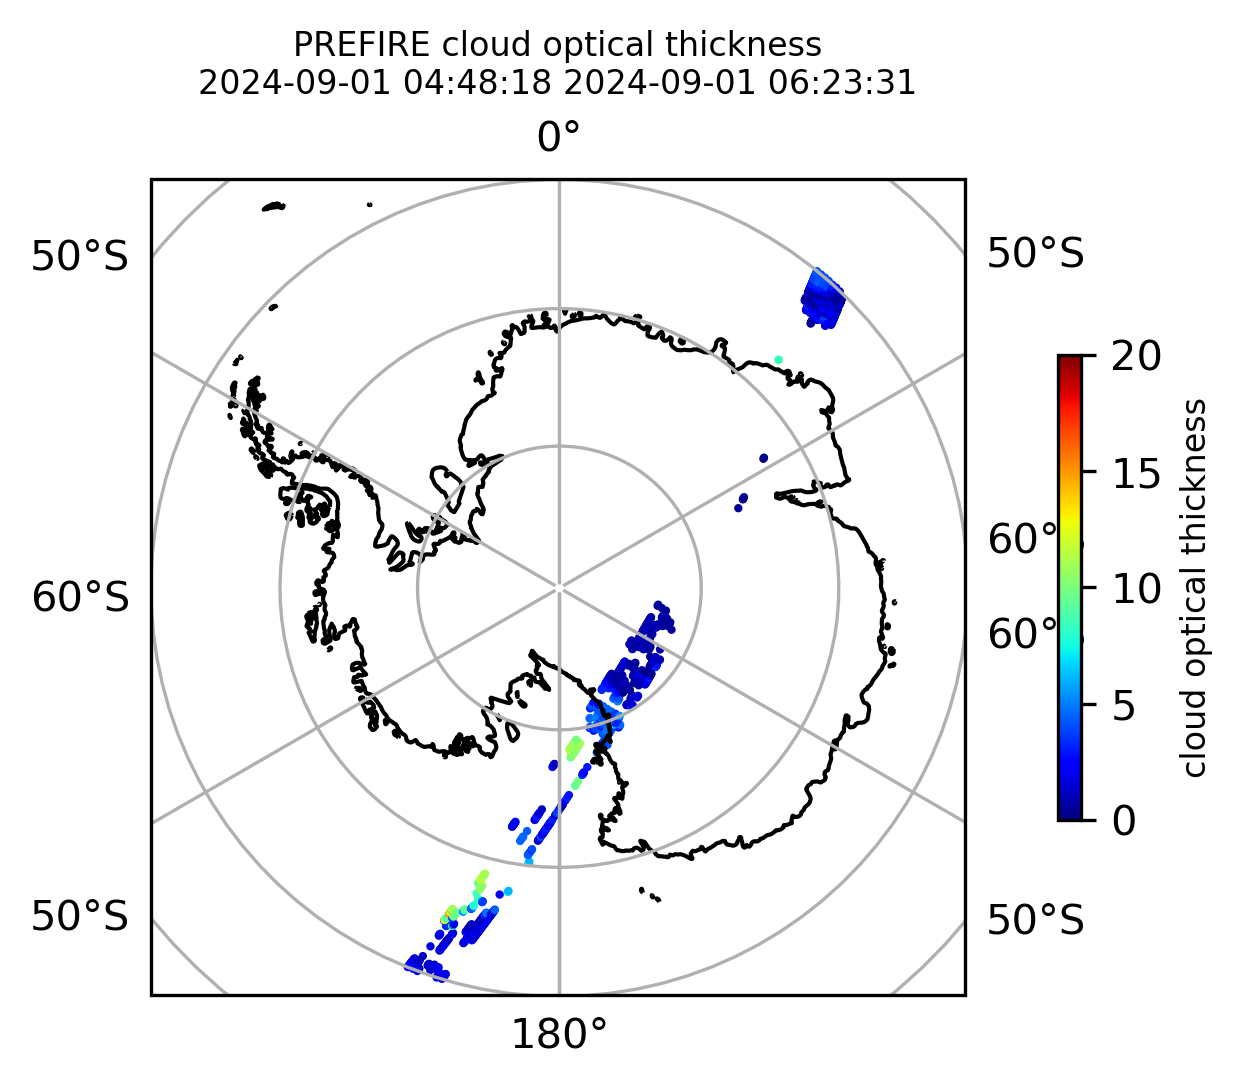

Generated plot for cloud optical thickness


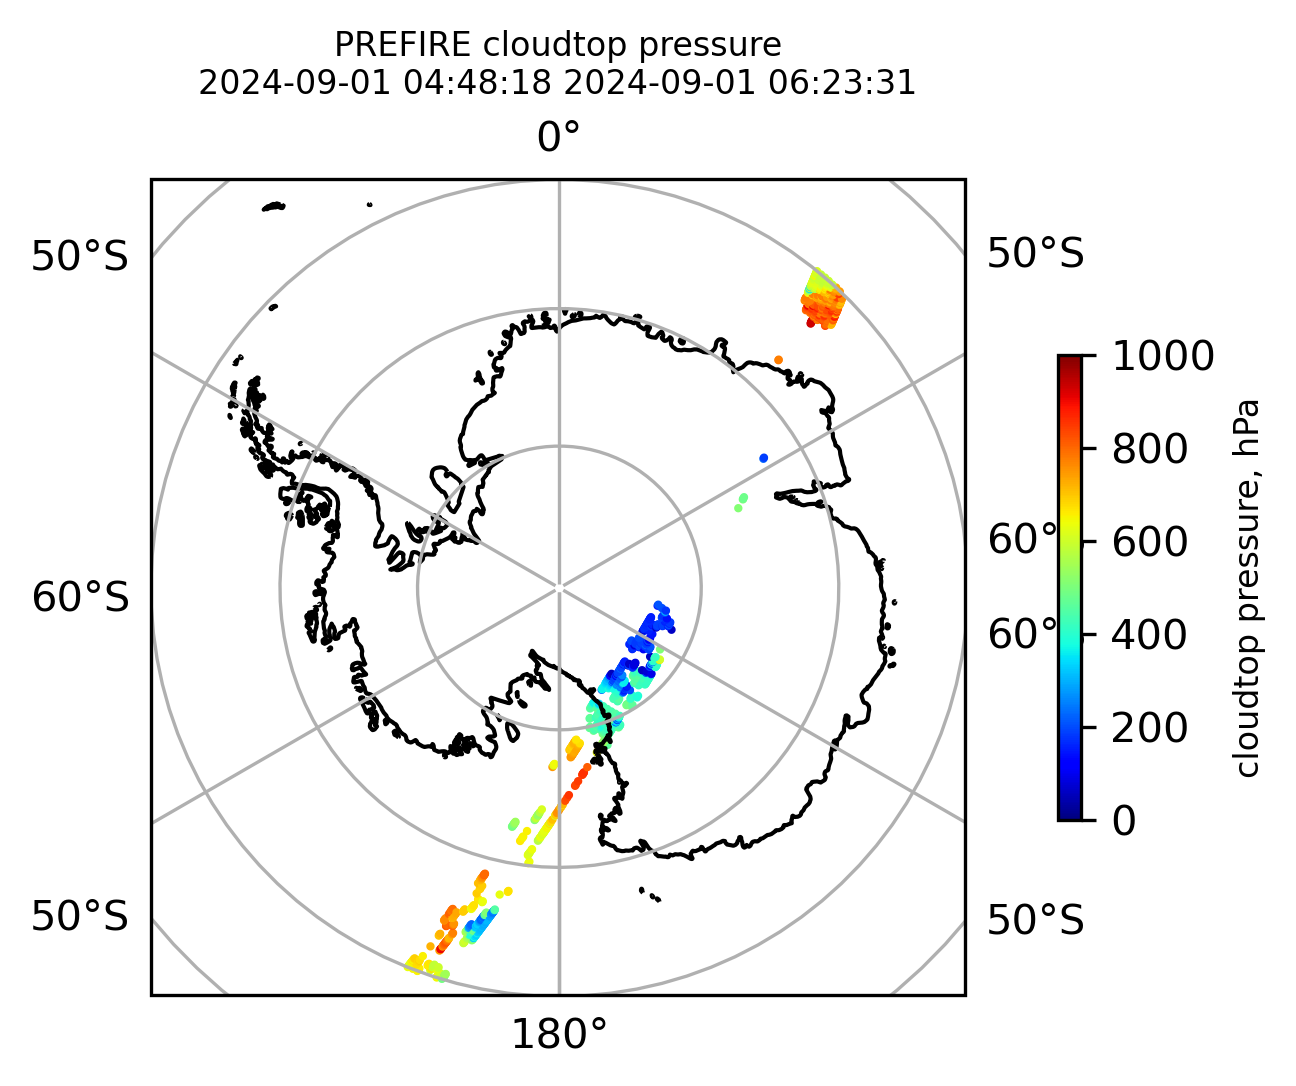

Generated plot for cloudtop pressure


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def find_valid_time_bounds(time_data, fill_value=-9999):
    """Find the first and last valid time entries in the dataset."""
    beginning_time = None
    ending_time = None
    
    # Find first valid time
    for time_row in time_data:
        if time_row[0] != fill_value:
            beginning_time = time_row
            break
    
    # Find last valid time (iterate backwards)
    for time_row in reversed(time_data):
        if time_row[0] != fill_value:
            ending_time = time_row
            break
    
    return beginning_time, ending_time

def format_time_strings(time_array):
    """Convert time array to formatted strings."""
    readable_time = f"{time_array[0]:4d}-{time_array[1]:02d}-{time_array[2]:02d} {time_array[3]:02d}:{time_array[4]:02d}:{time_array[5]:02d}"
    filename_time = f"{time_array[0]:4d}{time_array[1]:02d}{time_array[2]:02d}T{time_array[3]:02d}{time_array[4]:02d}{time_array[5]:02d}"
    return readable_time, filename_time

def create_data_masks(cloud_data, fill_values, quality_flags):
    """Create masks for valid cloud data based on fill values and quality flags."""
    masks = {}
    param_names = ['cloud_d_eff', 'cloud_tau', 'cloudtop_pressure']
    
    for i, param_name in enumerate(param_names):
        param_data = cloud_data[param_name]
        fill_val = fill_values[param_name]
        
        # Create mask for valid data (not fill value, finite, positive) and good quality flags
        masks[param_name] = (
            (param_data != fill_val) & 
            np.isfinite(param_data) & 
            (param_data > 0) & 
            (quality_flags == 0)
        )
    return masks

def extract_valid_data(data_dict, masks, lat_orig, lon_orig):
    """Extract valid data points and their corresponding coordinates."""
    valid_data = {}
    for param_name, param_data in data_dict.items():
        mask = masks[param_name]
        valid_data[param_name] = {
            'values': param_data[mask],
            'lat': lat_orig[mask],
            'lon': lon_orig[mask]
        }
    return valid_data

def create_orthographic_plot(data, param_config, time_str, filename_prefix):
    """Create an orthographic projection plot for cloud parameters."""
    if len(data['values']) == 0:
        print(f"No data to plot for {param_config['name']} during {time_str}")
        return
    
    fig = plt.figure(figsize=(4, 4), dpi=300, facecolor=None)
    proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
    transform = ccrs.PlateCarree()
    
    ax = fig.add_subplot(111, projection=proj)
    ax.set_extent([0.0, 360.0, -90.0, -60.0], crs=transform)
    
    scatter = ax.scatter(
        data['lon'], data['lat'],
        c=data['values'],
        s=1.0,
        cmap='jet',
        vmin=param_config['vmin'],
        vmax=param_config['vmax'],
        transform=transform
    )
    
    ax.coastlines(resolution="50m", color="black", linewidth=1)
    gl = ax.gridlines(draw_labels=True, dms=True)
    gl.xlabels_top = False
    gl.ylabels_left = False
    
    colorbar = plt.colorbar(
        scatter,
        ticks=param_config['ticks'],
        fraction=0.025,
        pad=0.1,
        orientation="vertical"
    )
    colorbar.set_label(param_config['label'], fontsize=8)
    ax.set_title(f"{param_config['title']}\n{time_str}", fontsize=8)
    
    plt.savefig(f"{filename_prefix}.png", dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()

def process_prefire_cloud_data(PREFIRE_names):
    """Main function to process PREFIRE cloud data."""
    
    # Configuration for different cloud parameters
    cloud_params = {
        'cloud_d_eff': {
            'name': 'cloud effective diameter',
            'title': 'PREFIRE CLD D$_{eff}$',
            'label': 'effective diameter, micron',
            'vmin': 0.0, 'vmax': 50.0,
            'ticks': [0, 10.0, 20.0, 30.0, 40.0, 50.0],
            'filename': 'PREFIRE_CLD_D_eff_SP'
        },
        'cloud_tau': {
            'name': 'cloud optical thickness',
            'title': 'PREFIRE cloud optical thickness',
            'label': 'cloud optical thickness',
            'vmin': 0.0, 'vmax': 20.0,
            'ticks': [0, 5.0, 10.0, 15.0, 20.0],
            'filename': 'PREFIRE_CLD_tau_SP'
        },
        'cloudtop_pressure': {
            'name': 'cloudtop pressure',
            'title': 'PREFIRE cloudtop pressure',
            'label': 'cloudtop pressure, hPa',
            'vmin': 0.0, 'vmax': 1000.0,
            'ticks': [0, 200.0, 400.0, 600.0, 800.0, 1000.0],
            'filename': 'PREFIRE_CLDTOP_pressure_SP'
        }
    }
    
    for name in PREFIRE_names:
        try:
            # Read PREFIRE data
            data_tuple = read_PREFIRE_2B_CLD(name)
            (ctime_orig, ctime_minus_UTC_orig, lat_orig, lon_orig, time_UTC_orig,
             bitQF_orig, cloud_d_eff_orig, fv_cloud_d_eff_orig, cloud_tau_orig,
             fv_cloud_tau_orig, cloudtop_pressure_orig, fv_cloudtop_pressure_orig) = data_tuple
            
            print(f"Processing file: {name}")
            
            # Find valid time bounds
            beginning_time_array, ending_time_array = find_valid_time_bounds(time_UTC_orig)
            
            if beginning_time_array is None or ending_time_array is None:
                print(f"No valid time data found in {name}")
                continue
            
            # Format time strings
            beginning_time, beginning_time_fn = format_time_strings(beginning_time_array)
            ending_time, ending_time_fn = format_time_strings(ending_time_array)
            time_range_str = f"{beginning_time} {ending_time}"
            
            print(f"Time range: {time_range_str}")
            
            # Organize cloud data and fill values
            cloud_data = {
                'cloud_d_eff': cloud_d_eff_orig,
                'cloud_tau': cloud_tau_orig,
                'cloudtop_pressure': cloudtop_pressure_orig
            }
            
            fill_values = {
                'cloud_d_eff': fv_cloud_d_eff_orig,
                'cloud_tau': fv_cloud_tau_orig,
                'cloudtop_pressure': fv_cloudtop_pressure_orig
            }
            
            # Create data masks
            masks = create_data_masks(cloud_data, fill_values, bitQF_orig)
            
            # Extract valid data
            valid_data = extract_valid_data(cloud_data, masks, lat_orig, lon_orig)
            
            # Generate plots for each parameter
            for param_name, param_config in cloud_params.items():
                try:
                    filename = f"{param_config['filename']}_{beginning_time_fn}_{ending_time_fn}"
                    create_orthographic_plot(
                        valid_data[param_name], 
                        param_config, 
                        time_range_str, 
                        filename
                    )
                    print(f"Generated plot for {param_config['name']}")
                except Exception as e:
                    print(f"Error creating plot for {param_config['name']}: {str(e)}")
            
        except Exception as e:
            print(f"Error processing file {name}: {str(e)}")
            continue

# Execute the processing (assuming PREFIRE_names is already defined)
# Make sure your read_PREFIRE_2B_CLD function and PREFIRE_names variable are available
process_prefire_cloud_data(PREFIRE_names)